In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wandb

In [2]:
api = wandb.Api()

# Train data

In [3]:
runs = [
    ("samoed-roman/PRGen/qal359h4", "Tune unsloth Phi-3-mini-4k-instruct"),
    ("samoed-roman/PRGen/dqxwq7rf", "Tune unsloth llama-3-8b-bnb-4bit"),
]

In [4]:
for run_api_path, run_name in runs:
    history = api.run(run_api_path).history(samples=1500)  # some steps duplicated
    history.to_csv(f"data/{run_name}.csv")

    train_columns = [col for col in history.columns if "train/" in col]
    eval_columns = [col for col in history.columns if "eval/" in col] + [
        "train/global_step"
    ]

    history[history["train/loss"].notna()][train_columns].to_csv(
        f"data/train_{run_name}.csv"
    )
    history[history["train/loss"].isna()][eval_columns].to_csv(
        f"data/eval_{run_name}.csv"
    )

In [5]:
import os

if not os.path.exists("plots"):
    os.makedirs("plots")

# Train plots

In [6]:
training_files = [
    ("data/train_Tune unsloth Phi-3-mini-4k-instruct.csv", "Phi-3"),
    ("data/train_Tune unsloth llama-3-8b-bnb-4bit.csv", "Llama-3"),
]

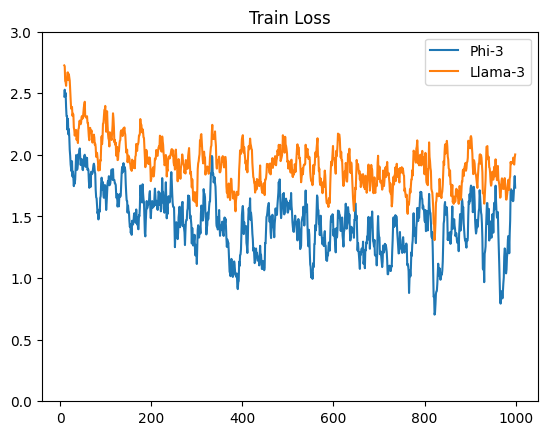

In [7]:
for file, model in training_files:
    df = pd.read_csv(file)
    plt.plot(df["train/loss"].rolling(10).mean(), label=model)
plt.title("Train Loss")
plt.ylim(bottom=0, top=3)
plt.legend()
plt.savefig("plots/loss.png", dpi=300)
plt.savefig("plots/loss.svg", dpi=300)
plt.show()

# Eval (train) plots

In [8]:
eval_files = [
    ("data/eval_Tune unsloth Phi-3-mini-4k-instruct.csv", "Phi-3", "--"),
    ("data/eval_Tune unsloth llama-3-8b-bnb-4bit.csv", "Llama-3", ""),
]

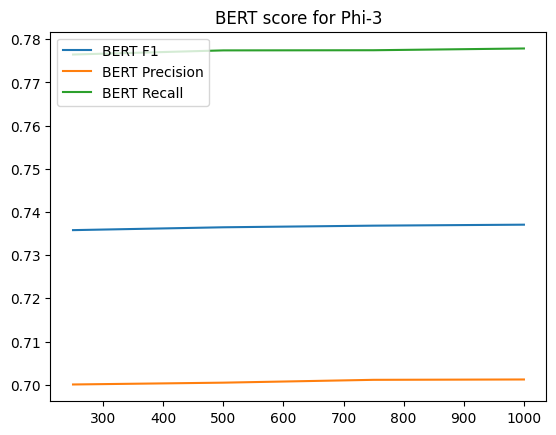

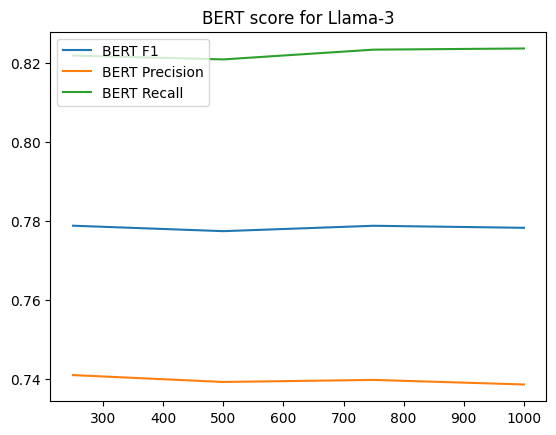

In [9]:
for file, model, _ in eval_files:
    df = pd.read_csv(file, index_col=0)
    df = df.reset_index(drop=True).set_index("train/global_step")

    bert_precision = [col for col in df.columns if "eval/bert_precision" in col]
    bert_recall = [col for col in df.columns if "eval/bert_recall" in col]
    bert_f1 = [col for col in df.columns if "eval/bert_f1" in col]

    df["eval/bert_f1"] = df[bert_f1].mean(axis=1).dropna()
    df["eval/bert_precision"] = df[bert_precision].mean(axis=1).dropna()
    df["eval/bert_recall"] = df[bert_recall].mean(axis=1).dropna()

    plt.plot(df["eval/bert_f1"], label="BERT F1")
    plt.plot(df["eval/bert_precision"], label="BERT Precision")
    plt.plot(df["eval/bert_recall"], label="BERT Recall")
    plt.title(f"BERT score for {model}")
    plt.legend()
    plt.savefig(f"plots/bert_{model}.png", dpi=300)
    plt.savefig(f"plots/bert_{model}.svg", dpi=300)
    plt.show()
# plt.savefig(f"plots/bert_{model}.pgf", dpi=300)
# plt.savefig(f"plots/bert_{model}.eps", dpi=300)

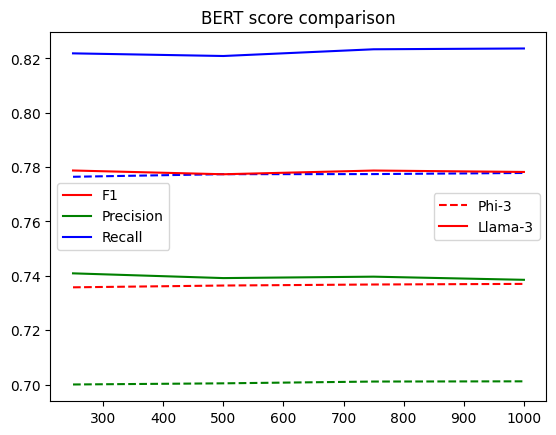

In [10]:
metric_handles = []  # To keep track of handles for metrics
model_handles = []  # To keep track of handles for models
model_names = []  # To keep model names for legend

for file, model, style in eval_files:
    df = pd.read_csv(file, index_col=0)
    df = df.reset_index(drop=True).set_index("train/global_step")

    bert_precision = [col for col in df.columns if "eval/bert_precision" in col]
    bert_recall = [col for col in df.columns if "eval/bert_recall" in col]
    bert_f1 = [col for col in df.columns if "eval/bert_f1" in col]

    df["eval/bert_f1"] = df[bert_f1].mean(axis=1).dropna()
    df["eval/bert_precision"] = df[bert_precision].mean(axis=1).dropna()
    df["eval/bert_recall"] = df[bert_recall].mean(axis=1).dropna()

    (f1_line,) = plt.plot(df["eval/bert_f1"], "r" + style, label="F1")
    (prec_line,) = plt.plot(df["eval/bert_precision"], "g" + style, label="Precision")
    (rec_line,) = plt.plot(df["eval/bert_recall"], "b" + style, label="Recall")

    # Add only the F1 line to model handles with correct model name
    model_handles.append(f1_line)
    model_names.append(model)

plt.title("BERT score comparison")

# Create a legend for the metrics
first_legend = plt.legend(
    handles=[f1_line, prec_line, rec_line],
    labels=["F1", "Precision", "Recall"],
    loc="center left",
)
plt.gca().add_artist(first_legend)

# Create another legend for the models with their specific line styles
# Use model names for the labels
model_legend = plt.legend(handles=model_handles, labels=model_names, loc="center right")
plt.savefig("plots/bert.png", dpi=300)
plt.savefig("plots/bert.svg", dpi=300)
plt.show()

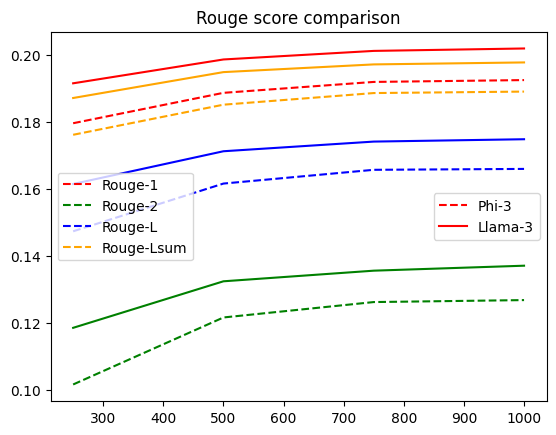

In [11]:
metric_handles = []  # To keep handles for metrics (if needed)
model_handles = []  # To keep handles for each model's lines
model_labels = []  # To store model names for the legend

for file, model, style in eval_files:
    df = pd.read_csv(file, index_col=0)
    df = df.reset_index(drop=True).set_index("train/global_step")

    # Plot each metric with a unique line style
    (r1,) = plt.plot(df["eval/rouge1"], "r" + style, label="Rouge-1")
    (r2,) = plt.plot(df["eval/rouge2"], "g" + style, label="Rouge-2")
    (rl,) = plt.plot(df["eval/rougeL"], "b" + style, label="Rouge-L")
    (rlsum,) = plt.plot(df["eval/rougeLsum"], style, label="Rouge-Lsum", color="orange")

    # Collect metric handles only once
    if not metric_handles:
        metric_handles.extend([r1, r2, rl, rlsum])

    # Add one line for this model to the model legend
    # (you can choose any of the metric lines to represent the model)
    model_handles.append(r1)
    model_labels.append(model)

plt.title("Rouge score comparison")

# Create a legend for the metrics
first_legend = plt.legend(handles=metric_handles, loc="center left")
plt.gca().add_artist(first_legend)

# Create another legend for the models with their specific model names
model_legend = plt.legend(
    handles=model_handles, labels=model_labels, loc="center right"
)

plt.savefig("plots/rouge.png", dpi=300)
plt.savefig("plots/rouge.svg", dpi=300)
plt.show()

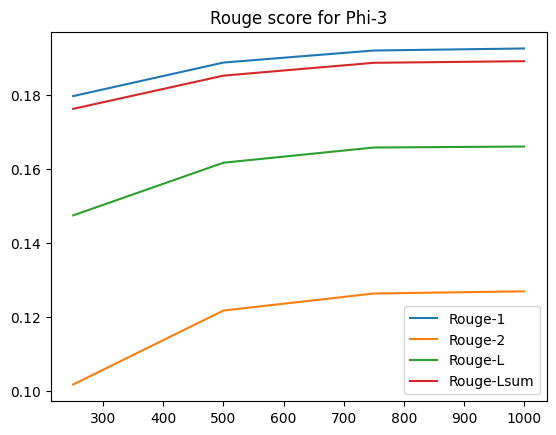

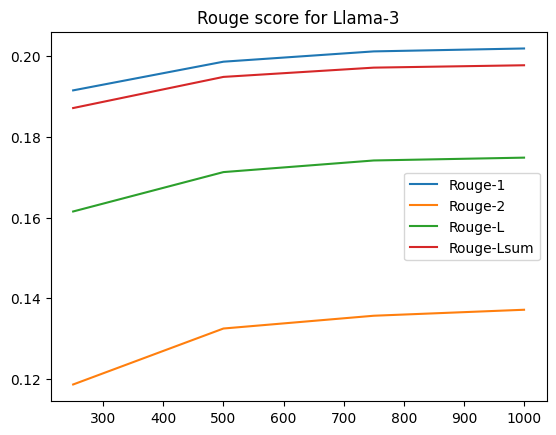

In [12]:
for file, model, _ in eval_files:
    df = pd.read_csv(file, index_col=0)
    df = df.reset_index(drop=True).set_index("train/global_step")

    plt.plot(df["eval/rouge1"], label="Rouge-1")
    plt.plot(df["eval/rouge2"], label="Rouge-2")
    plt.plot(df["eval/rougeL"], label="Rouge-L")
    plt.plot(df["eval/rougeLsum"], label="Rouge-Lsum")
    plt.title(f"Rouge score for {model}")
    plt.legend()
    plt.savefig(f"plots/rouge_{model}.png", dpi=300)
    plt.savefig(f"plots/rouge_{model}.svg", dpi=300)
    plt.show()
    # plt.savefig(f"plots/bert_{model}.pgf", dpi=300)
    # plt.savefig(f"plots/bert_{model}.eps", dpi=300)

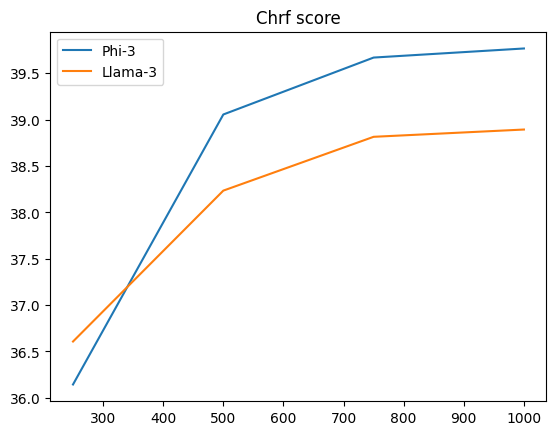

In [13]:
for file, model, _ in eval_files:
    df = pd.read_csv(file, index_col=0)
    df = df.reset_index(drop=True).set_index("train/global_step")

    plt.plot(df["eval/score"], label=model)
plt.title("Chrf score")
plt.legend()
plt.savefig("plots/chrf.png", dpi=300)
plt.savefig("plots/chrf.svg", dpi=300)
plt.show()

# Eval results

In [14]:
runs = [
    ("samoed-roman/PRGen/fgvjmqjn", "LoRA-Phi-3"),
    ("samoed-roman/PRGen/e1az8sv4", "Phi-3"),
    ("samoed-roman/PRGen/9rqnz07i", "LLama-3"),
    ("samoed-roman/PRGen/7zkz50yf", "LoRA-LLama-3"),
]

In [15]:
prefix = "eval_val_"
for run_api_path, run_name in runs:
    history = api.run(run_api_path).history(samples=1500)  # some steps duplicated
    history.to_csv(f"data/{prefix}{run_name}.csv")

In [16]:
files = [
    ("data/" + f, f[len(prefix) :].split(".")[0])
    for f in os.listdir("data")
    if f.startswith("eval_val_")
]
files

[('data/eval_val_LoRA-Phi-3.csv', 'LoRA-Phi-3'),
 ('data/eval_val_LLama-3.csv', 'LLama-3'),
 ('data/eval_val_LoRA-LLama-3.csv', 'LoRA-LLama-3'),
 ('data/eval_val_Phi-3.csv', 'Phi-3')]

In [17]:
# combine all files and add field for model name
df = pd.concat(
    [pd.read_csv(f, index_col=0).assign(model_name=model) for f, model in files]
)
df.head()

,_step,char_order,rougeLsum,score,_runtime,bert_precision,rouge2,rouge1,bert_recall,bert_f1,word_order,rougeL,_timestamp,beta,model_name
0,0,6,0.119803,5.491825,59.152527,0.853422,0.046181,0.127504,0.799090,0.824394,2,0.115129,1.716062e+09,2,LoRA-Phi-3
0,0,6,0.134487,7.392158,66.137899,0.851649,0.041733,0.152039,0.809838,0.829207,2,0.121607,1.716062e+09,2,LLama-3
0,0,6,0.149010,2.747797,51.151780,0.871320,0.063561,0.154895,0.803862,0.835317,2,0.145994,1.716062e+09,2,LoRA-LLama-3
0,0,6,0.102561,9.683055,75.963046,0.822622,0.027230,0.118331,0.801105,0.810529,2,0.085946,1.716062e+09,2,Phi-3


In [18]:
df.to_csv("data/combined.csv")

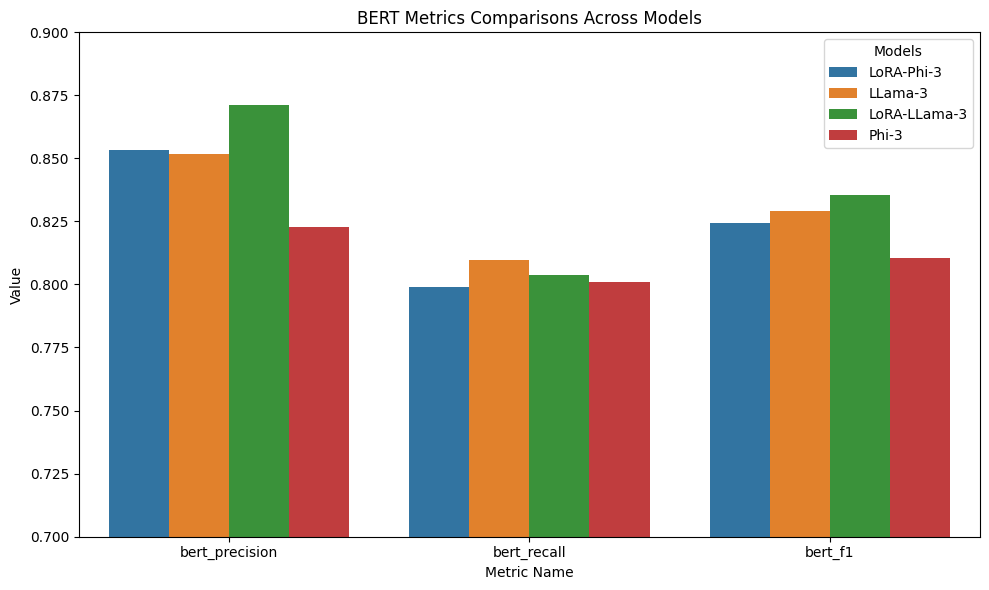

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Melt DataFrame to get 'variable' and 'value' columns for Seaborn
melted_df = df.melt(
    value_vars=["bert_precision", "bert_recall", "bert_f1"],
    id_vars="model_name",
    var_name="Metric",
    value_name="Value",
)

# Create seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Metric", y="Value", hue="model_name")
plt.title("BERT Metrics Comparisons Across Models")
plt.xlabel("Metric Name")
# plt.xticks(rotation=45)
plt.legend(title="Models")
plt.ylim(0.7, 0.9)
plt.tight_layout()
plt.savefig("plots/eval_bert_metrics.png", dpi=300)
plt.savefig("plots/eval_bert_metrics.svg", dpi=300)
plt.show()

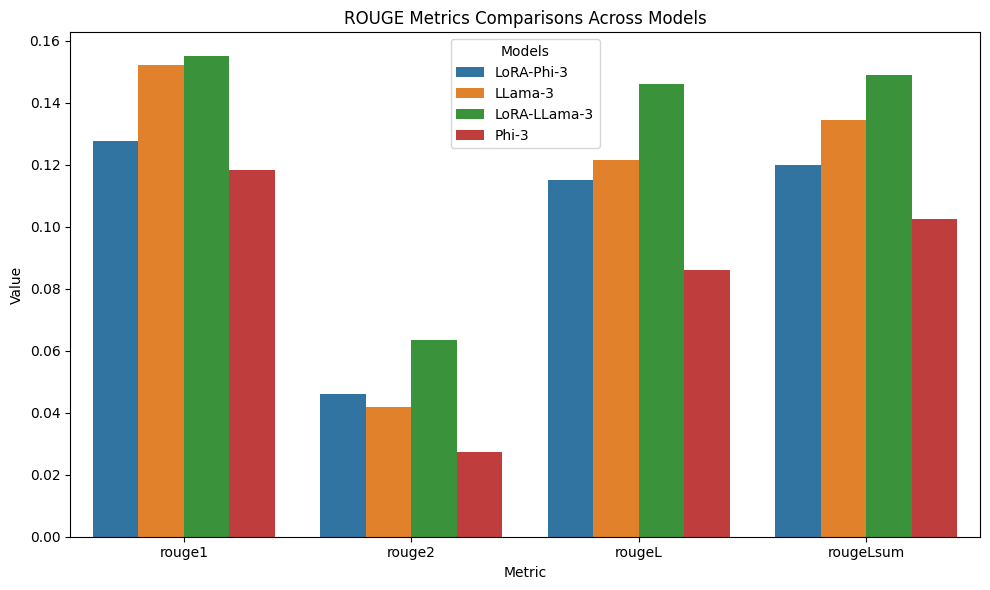

In [20]:
rouge_metrics_df = df.melt(
    value_vars=["rouge1", "rouge2", "rougeL", "rougeLsum"],
    id_vars="model_name",
    var_name="Metric",
    value_name="Value",
)

# Create seaborn barplot for ROUGE metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=rouge_metrics_df, x="Metric", y="Value", hue="model_name")
plt.title("ROUGE Metrics Comparisons Across Models")
plt.xlabel("Metric")
# plt.ylabel("Metric Value")
# plt.xticks(rotation=45)
plt.legend(title="Models")
plt.tight_layout()
plt.savefig("plots/eval_rouge_metrics.png", dpi=300)
plt.savefig("plots/eval_rouge_metrics.svg", dpi=300)
plt.show()

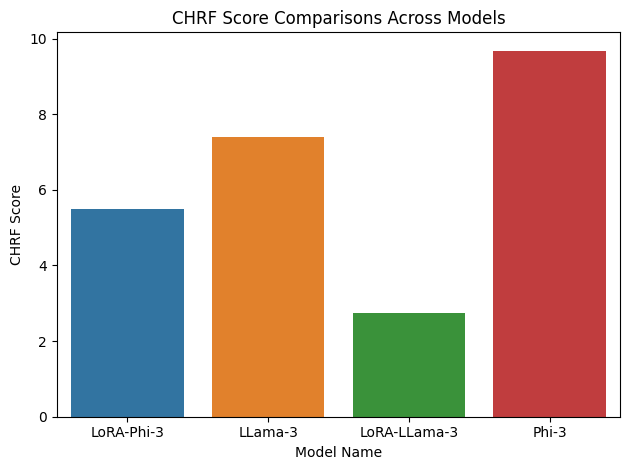

In [21]:
sns.barplot(data=df, x="model_name", y="score", hue="model_name")
plt.title("CHRF Score Comparisons Across Models")
plt.xlabel("Model Name")
plt.ylabel("CHRF Score")
plt.tight_layout()
plt.savefig("plots/eval_chrf_score.png", dpi=300)
plt.savefig("plots/eval_chrf_score.svg", dpi=300)
plt.show()

In [22]:
import pandas as pd

pd.read_csv("data/combined2.csv").to_latex(
    "data/combined.tex", float_format="{:.5f}".format, escape=True, index=False
)